**Import the dataset**

In [1]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

# metadata
print(adult.metadata)

# variable information
print(adult.variables)

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Aug 07 2023', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAG

Import the libraries

In [2]:
import pandas as pds
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plts
import seaborn as sns

**Data pre-processing**

In [3]:
# Load the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
                'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

data = pds.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)

# Handling missing values
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].str.strip()  # Strip leading/trailing whitespaces
        mode_val = data[col].mode()[0]
        data[col].fillna(mode_val, inplace=True)
    else:
        median_val = data[col].median()
        data[col].fillna(median_val, inplace=True)

# Handling inconsistent data
data['sex'] = data['sex'].str.lower()

# Handle irrelevant data
data.drop('fnlwgt', axis=1, inplace=True)

# Handling imbalanced data using SMOTE
X = data.drop('income', axis=1)
y = data['income']

# Apply one-hot encoding to categorical variables
X = pds.get_dummies(X, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Printing the data before cleaning
print("Data before cleaning:")
print(data.head().to_string(index=False))

# Show data after cleaning
print("\nData after cleaning:")
print(X.head().to_string(index=False))

Data before cleaning:
 age        workclass education  education-num     marital-status        occupation  relationship  race    sex  capital-gain  capital-loss  hours-per-week native-country income
  39        State-gov Bachelors             13      Never-married      Adm-clerical Not-in-family White   male          2174             0              40  United-States  <=50K
  50 Self-emp-not-inc Bachelors             13 Married-civ-spouse   Exec-managerial       Husband White   male             0             0              13  United-States  <=50K
  38          Private   HS-grad              9           Divorced Handlers-cleaners Not-in-family White   male             0             0              40  United-States  <=50K
  53          Private      11th              7 Married-civ-spouse Handlers-cleaners       Husband Black   male             0             0              40  United-States  <=50K
  28          Private Bachelors             13 Married-civ-spouse    Prof-specialty          

**Data Visualization**

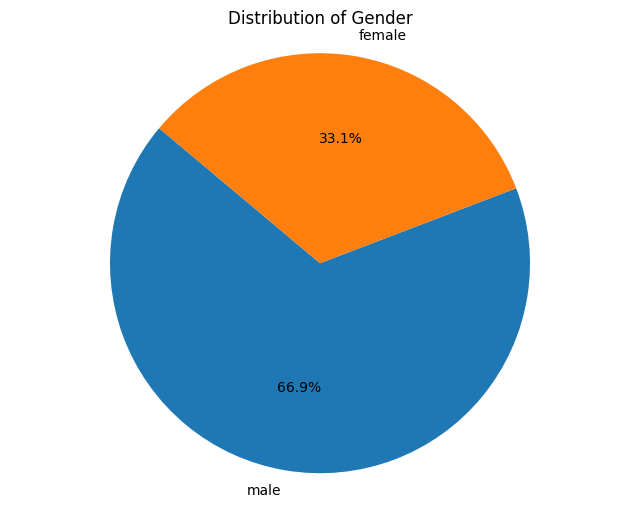

In [4]:
# Count the occurrences of each gender
gender_counts = data['sex'].value_counts()

# Create a pie chart
plts.figure(figsize=(8, 6))
plts.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plts.title('Distribution of Gender')
plts.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plts.show()


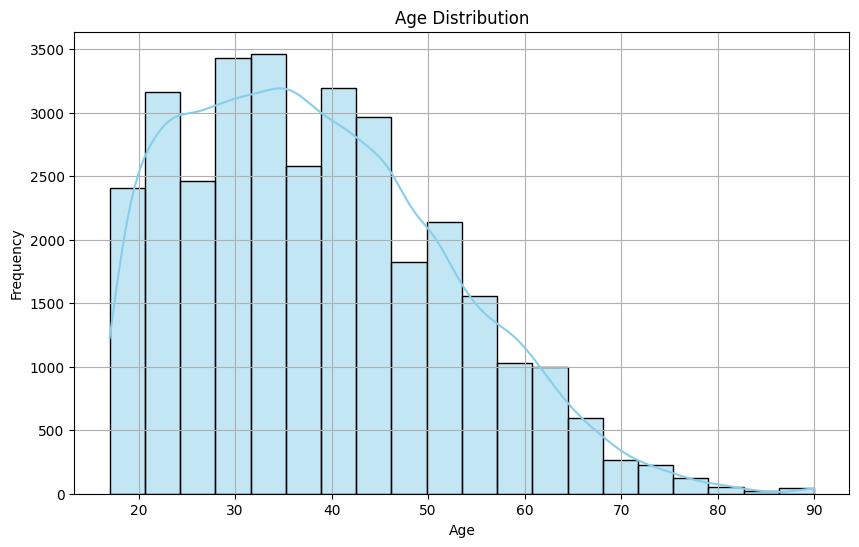

In [5]:
# Create a histogram for age distribution
plts.figure(figsize=(10, 6))
sns.histplot(data['age'], bins=20, kde=True, color='skyblue', edgecolor='black')
plts.title('Age Distribution')
plts.xlabel('Age')
plts.ylabel('Frequency')
plts.grid(True)
plts.show()

<ipython-input-6-7a50df124954>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data['education'], palette='Set2', order=data['education'].value_counts().index)


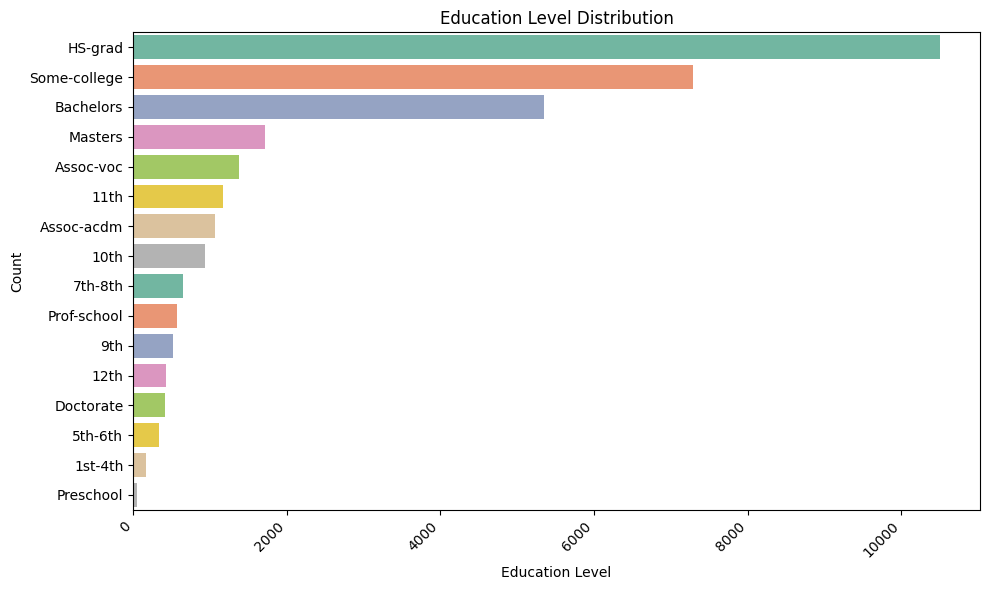

In [6]:
# Create a count plot for education level
plts.figure(figsize=(10, 6))
sns.countplot(data['education'], palette='Set2', order=data['education'].value_counts().index)
plts.title('Education Level Distribution')
plts.xlabel('Education Level')
plts.ylabel('Count')
plts.xticks(rotation=45, ha='right')
plts.tight_layout()
plts.show()

<ipython-input-7-30128b0ee72c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data['occupation'], palette='Set3', order=data['occupation'].value_counts().index)


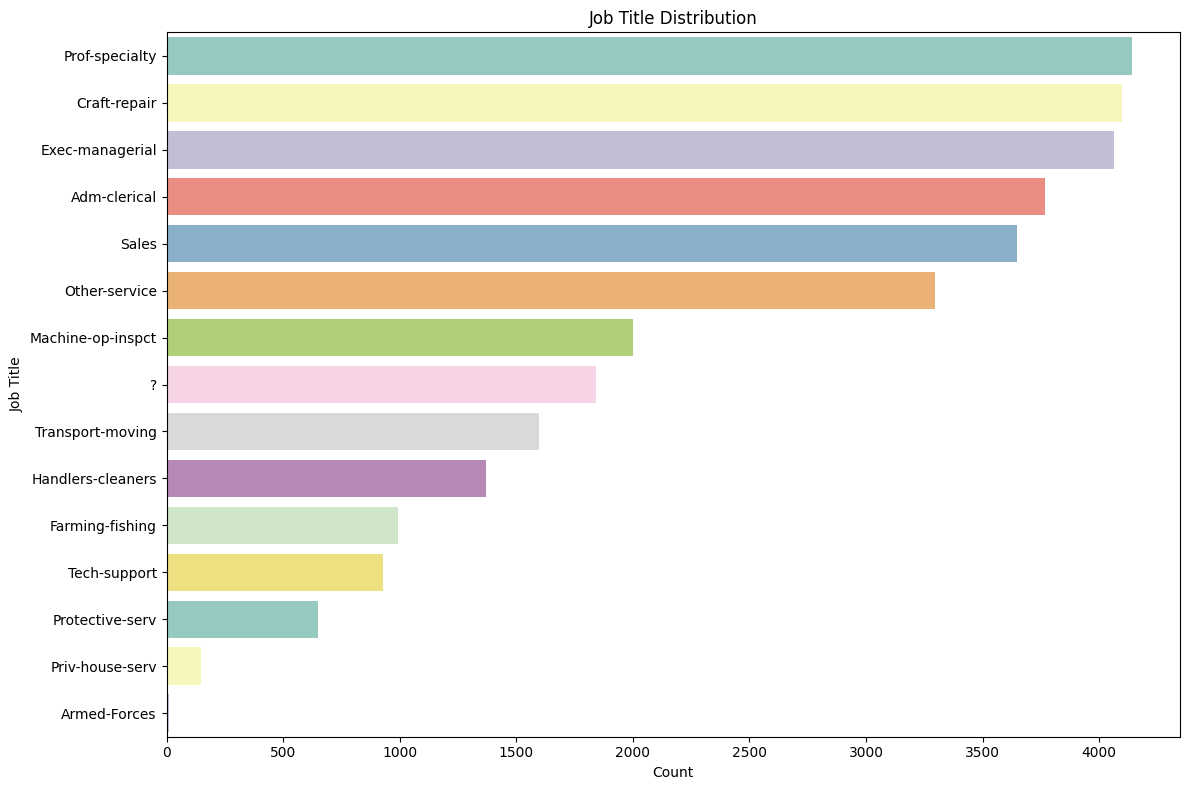

In [7]:
# Create a count plot for job title
plts.figure(figsize=(12, 8))
sns.countplot(y=data['occupation'], palette='Set3', order=data['occupation'].value_counts().index)
plts.title('Job Title Distribution')
plts.xlabel('Count')
plts.ylabel('Job Title')
plts.tight_layout()
plts.show()

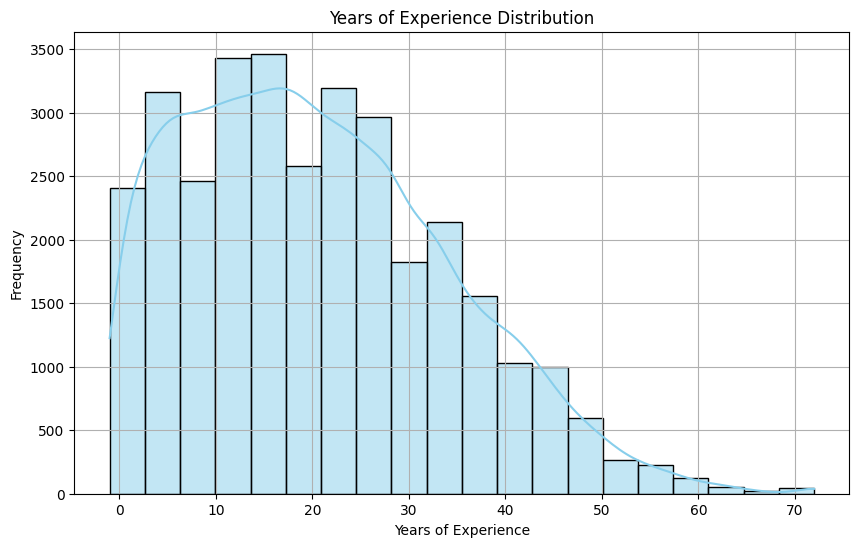

In [8]:
# Calculate years of experience
data['years_of_experience'] = data['age'] - 18

# Create a histogram for years of experience
plts.figure(figsize=(10, 6))
sns.histplot(data['years_of_experience'], bins=20, kde=True, color='skyblue', edgecolor='black')
plts.title('Years of Experience Distribution')
plts.xlabel('Years of Experience')
plts.ylabel('Frequency')
plts.grid(True)
plts.show()

<ipython-input-9-ed0ca185e289>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data['native-country'], palette='Set3', order=data['native-country'].value_counts().index)


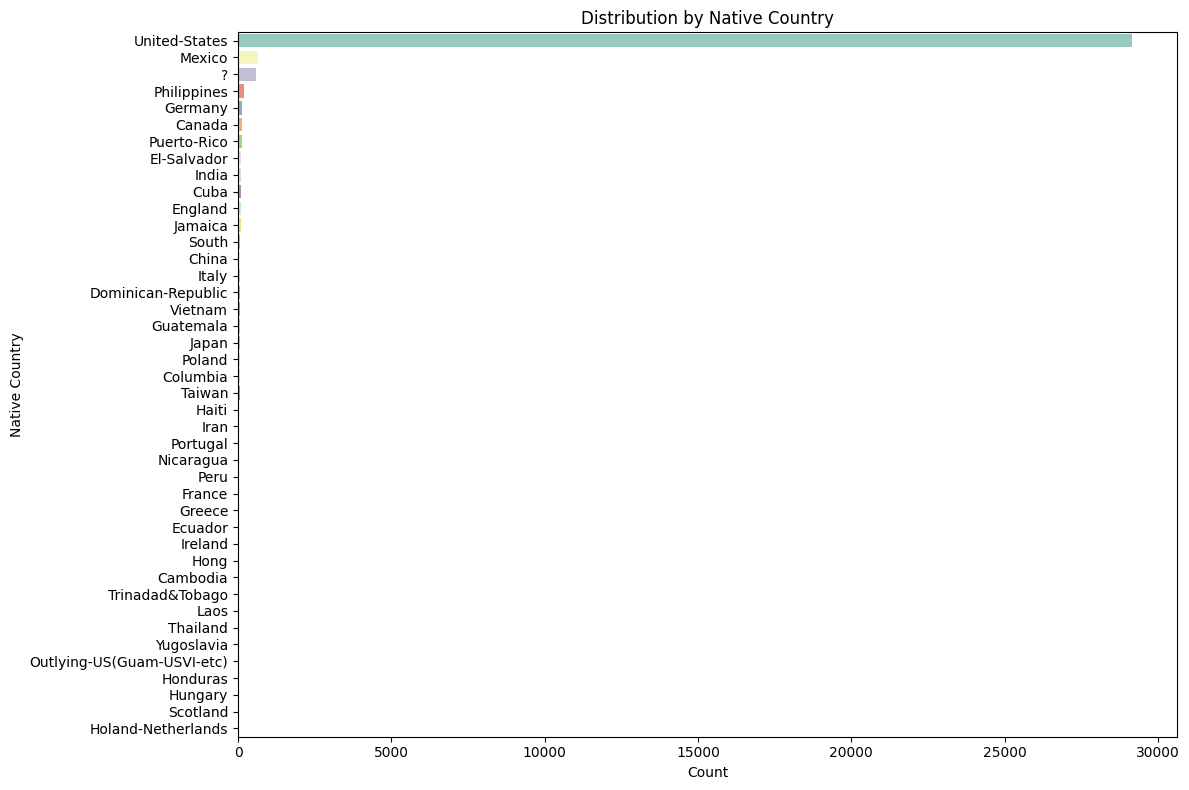

In [9]:
# Create a count plot for native country
plts.figure(figsize=(12, 8))
sns.countplot(y=data['native-country'], palette='Set3', order=data['native-country'].value_counts().index)
plts.title('Distribution by Native Country')
plts.xlabel('Count')
plts.ylabel('Native Country')
plts.tight_layout()
plts.show()

<ipython-input-10-cb6901a4eb01>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data['race'], palette='Set1', order=data['race'].value_counts().index)


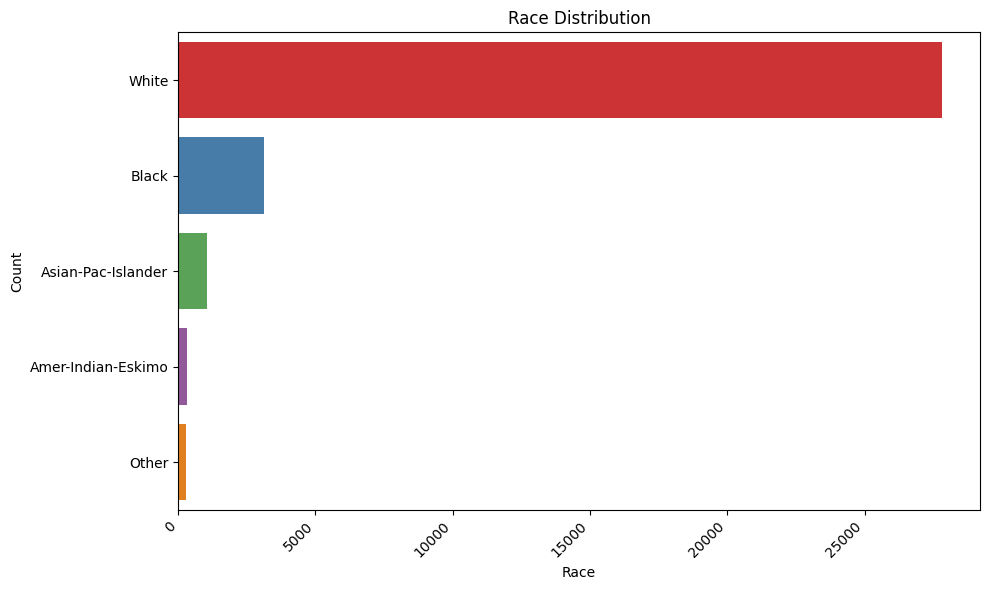

In [10]:
# Create a count plot for race distribution
plts.figure(figsize=(10, 6))
sns.countplot(data['race'], palette='Set1', order=data['race'].value_counts().index)
plts.title('Race Distribution')
plts.xlabel('Race')
plts.ylabel('Count')
plts.xticks(rotation=45, ha='right')
plts.tight_layout()
plts.show()


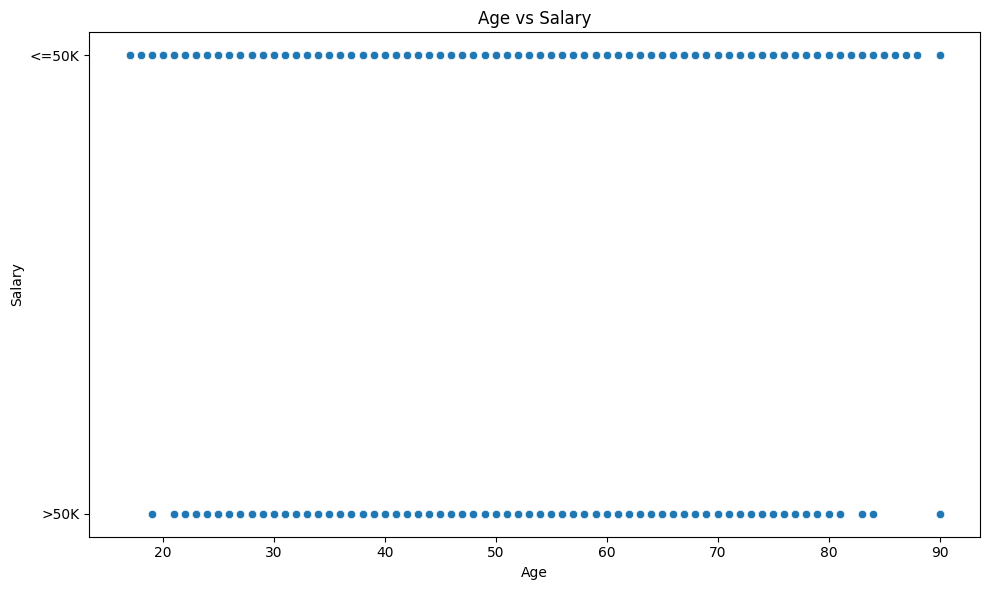

In [11]:
# Assuming 'Salary' column represents the income
plts.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='income', data=data)
plts.title('Age vs Salary')
plts.xlabel('Age')
plts.ylabel('Salary')
plts.tight_layout()
plts.show()


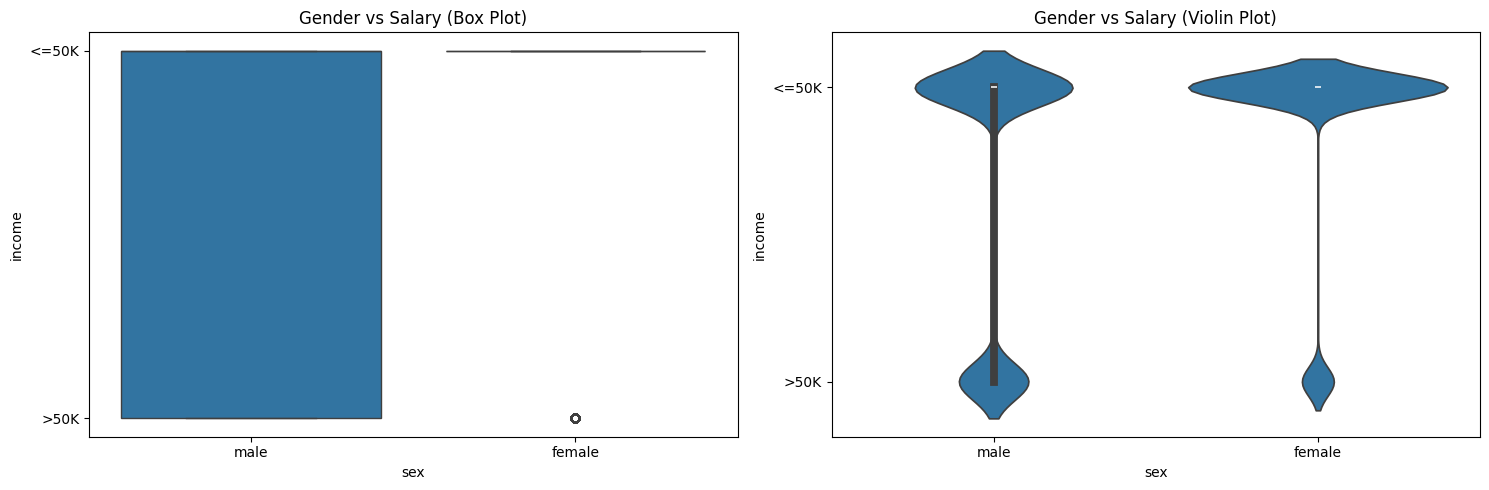

In [12]:
fig, ax = plts.subplots(1, 2, figsize=(15, 5))

# Box plot for Gender vs Salary
sns.boxplot(x='sex', y='income', data=data, ax=ax[0])
ax[0].set_title('Gender vs Salary (Box Plot)')

# Violin plot for Gender vs Salary
sns.violinplot(x='sex', y='income', data=data, ax=ax[1])
ax[1].set_title('Gender vs Salary (Violin Plot)')

plts.tight_layout()
plts.show()


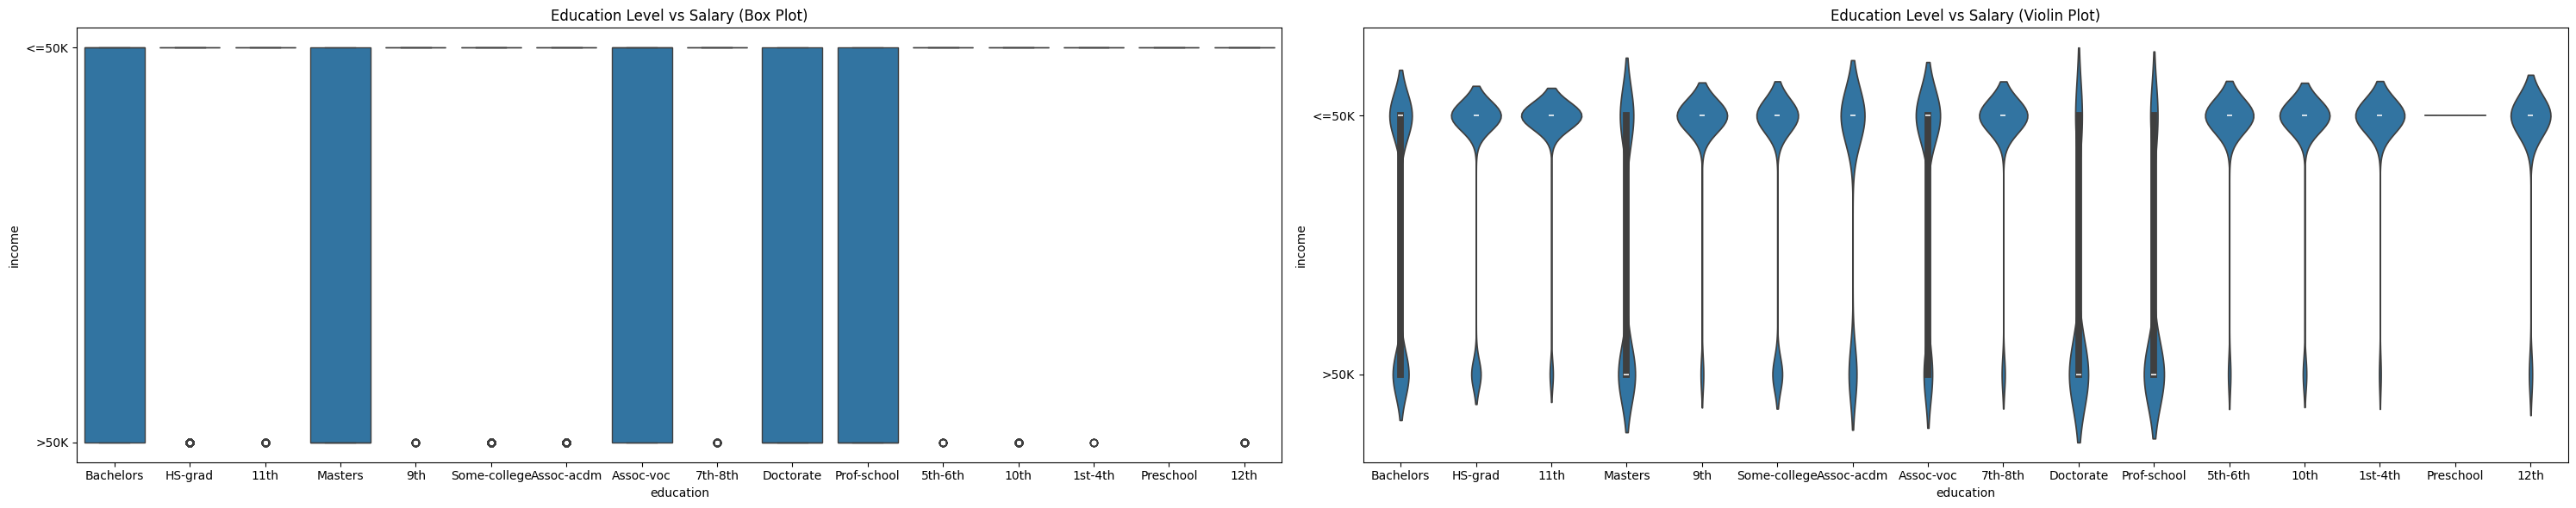

In [13]:
fig, ax = plts.subplots(1, 2, figsize=(30, 6))

# Box plot for Education Level vs Salary
sns.boxplot(x='education', y='income', data=data, ax=ax[0])
ax[0].set_title('Education Level vs Salary (Box Plot)')

# Violin plot for Education Level vs Salary
sns.violinplot(x='education', y='income', data=data, ax=ax[1])
ax[1].set_title('Education Level vs Salary (Violin Plot)')

plts.tight_layout()
plts.show()


<ipython-input-14-3dcd1b399a62>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='occupation', y='income', data=data, palette='Set2')


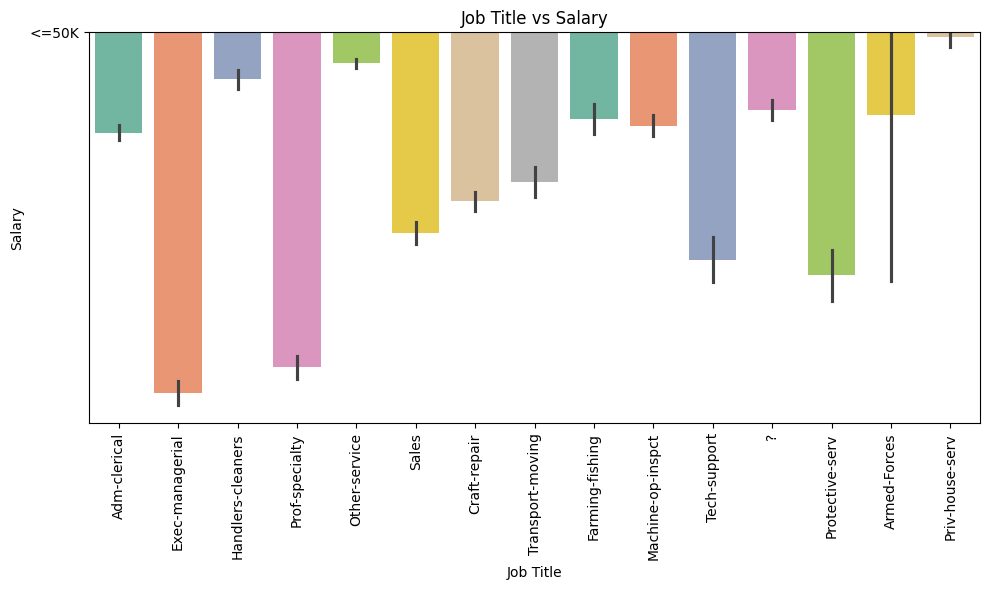

In [14]:
plts.figure(figsize=(10, 6))

# Bar plot for Job Title vs Salary
sns.barplot(x='occupation', y='income', data=data, palette='Set2')
plts.title('Job Title vs Salary')
plts.xlabel('Job Title')
plts.ylabel('Salary')
plts.xticks(rotation=90)
plts.tight_layout()
plts.show()


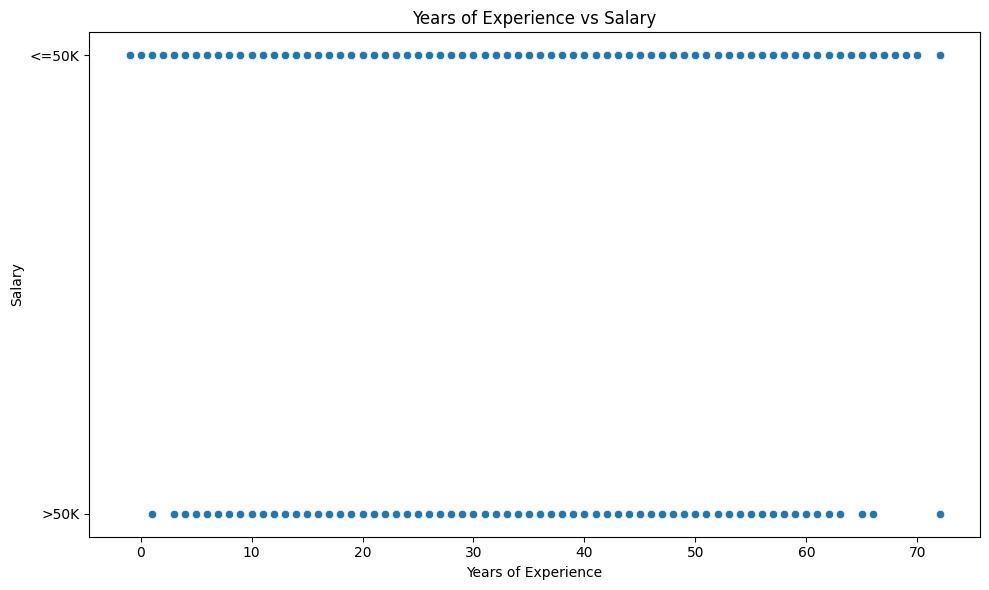

In [15]:
plts.figure(figsize=(10, 6))

# Scatter plot for Years of Experience vs Salary
sns.scatterplot(x='years_of_experience', y='income', data=data)
plts.title('Years of Experience vs Salary')
plts.xlabel('Years of Experience')
plts.ylabel('Salary')
plts.tight_layout()
plts.show()


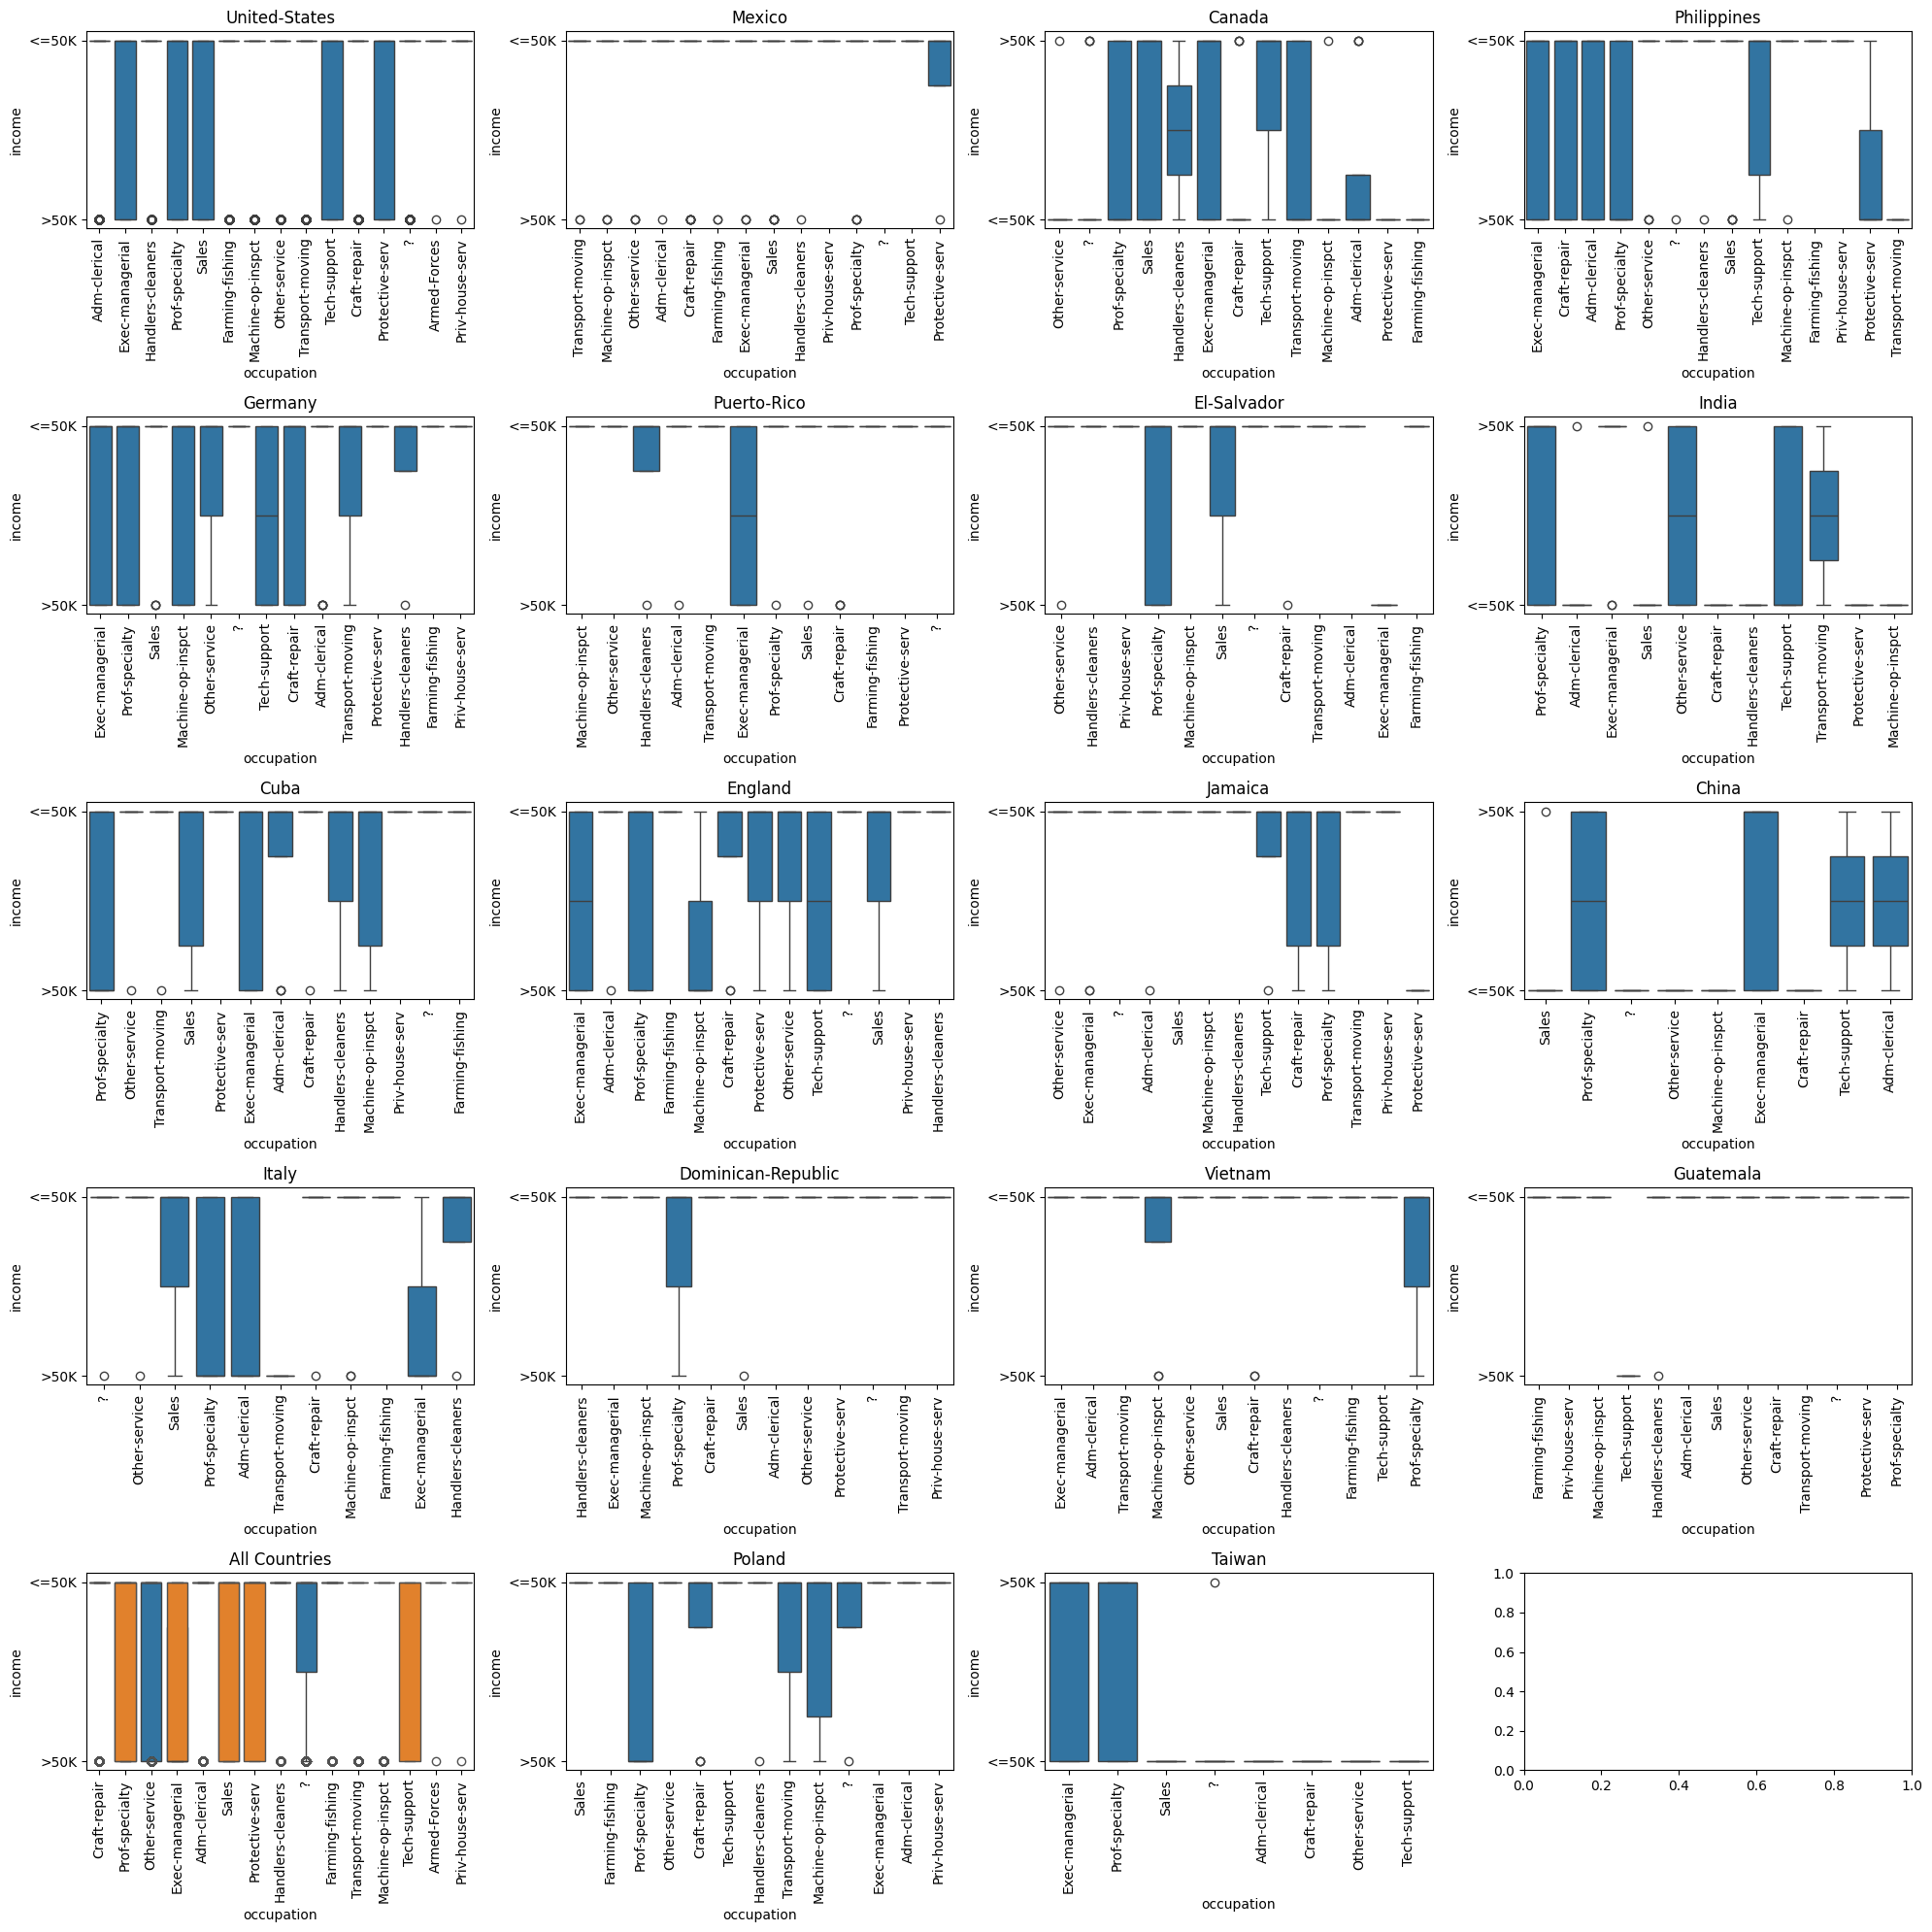

In [16]:
fig, ax = plts.subplots(5, 4, figsize=(20, 20))
plts.subplots_adjust(hspace=0.5)

# Loop through each country and create box plots
countries = ['United-States', 'Mexico', 'Canada', 'Philippines', 'Germany', 'Puerto-Rico', 'El-Salvador', 'India', 'Cuba', 'England', 'Jamaica', 'China', 'Italy', 'Dominican-Republic', 'Vietnam', 'Guatemala', 'Japan', 'Poland', 'Taiwan']
for i, country in enumerate(countries):
    row = i // 4
    col = i % 4
    sns.boxplot(x='occupation', y='income', data=data[data['native-country'] == country], ax=ax[row, col]).set_title(country)
    ax[row, col].tick_params(axis='x', rotation=90)

# Plot for all countries
sns.boxplot(x='occupation', y='income', data=data, ax=ax[4, 0]).set_title('All Countries')
ax[4, 0].tick_params(axis='x', rotation=90)

plts.tight_layout()
plts.show()


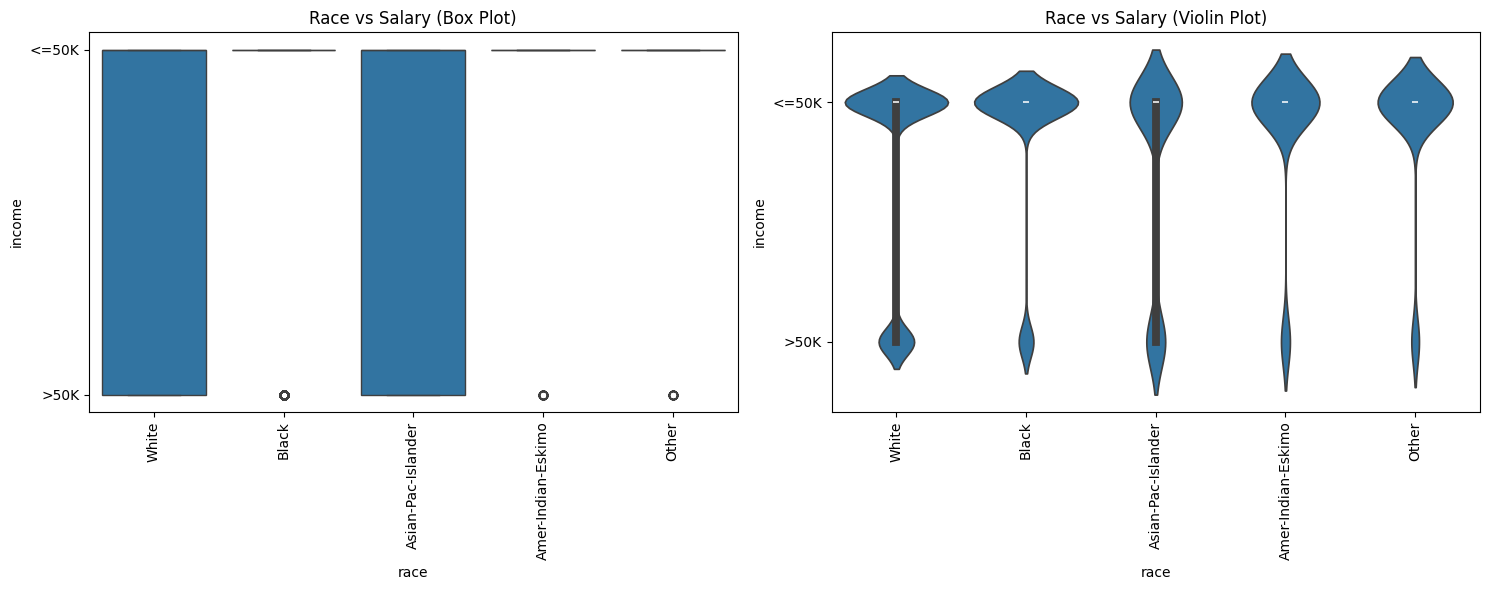

In [17]:
fig, ax = plts.subplots(1, 2, figsize=(15, 6))

# Box plot for Race vs Salary
sns.boxplot(x='race', y='income', data=data, ax=ax[0])
ax[0].set_title('Race vs Salary (Box Plot)')
ax[0].tick_params(axis='x', rotation=90)

# Violin plot for Race vs Salary
sns.violinplot(x='race', y='income', data=data, ax=ax[1])
ax[1].set_title('Race vs Salary (Violin Plot)')
ax[1].tick_params(axis='x', rotation=90)

plts.tight_layout()
plts.show()


**Naïve Bayes model**

In [22]:
# Naïve Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Predictions
y_pred_nb = nb_model.predict(X_test)

# Evaluation
accuracy_nb = accuracy_score(y_test, y_pred_nb)
report_nb = classification_report(y_test, y_pred_nb)

print(f'Naïve Bayes Accuracy: {accuracy_nb}')
print('Classification Report (Naïve Bayes):')
print(report_nb)


Naïve Bayes Accuracy: 0.8057730692461231
Classification Report (Naïve Bayes):
              precision    recall  f1-score   support

       <=50K       0.94      0.80      0.86      4942
        >50K       0.57      0.83      0.67      1571

    accuracy                           0.81      6513
   macro avg       0.75      0.81      0.77      6513
weighted avg       0.85      0.81      0.82      6513



**Random Forest classification:**

In [23]:
# Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print(f'Random Forest Accuracy: {accuracy_rf}')
print('Classification Report (Random Forest):')
print(report_rf)

Random Forest Accuracy: 0.8575157377552587
Classification Report (Random Forest):
              precision    recall  f1-score   support

       <=50K       0.87      0.96      0.91      4942
        >50K       0.80      0.55      0.65      1571

    accuracy                           0.86      6513
   macro avg       0.83      0.75      0.78      6513
weighted avg       0.85      0.86      0.85      6513



In [24]:
# Compare the models and showcase the results
accuracy_nb_percent = round(accuracy_nb * 100, 2)
accuracy_rf_percent = round(accuracy_rf * 100, 2)

#Show Naïve Bayes Accuracy rate
print(f'Naïve Bayes Accuracy: {accuracy_nb_percent}%')

#Show Random Forest Accuracy rate
print(f'\nRandom Forest Accuracy: {accuracy_rf_percent}%')


Naïve Bayes Accuracy: 80.58%

Random Forest Accuracy: 85.75%
